# Expanding on Ito et al. (2017) to recover simulated task activity and connectivity matrix


Set up environment

In [1]:
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

Import custom modules

In [2]:
sys.path.append('../')
sys.path.append('../../utils/')

# Primary module with most model functions
import model

# Module for FC regression
import multregressionconnectivity as mreg

Helper functions

In [3]:
phi = lambda x: np.tanh(x)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def pshift(y,p):
    y_lag = np.roll(y, p)
    y_lag[:p] = 0
    return y_lag


## Neural network level

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}


where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

In [ ]:
plt.rcParams["figure.figsize"][0] = 6
plt.rcParams["figure.figsize"][1] = 5
a = np.random.normal(size=100)
pa = phi(a)
plt.plot(a, label="Untransformed")
plt.plot(pa, label="Transformed")
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axhline(y=-1,linewidth=2, color='gray', ls = "--")
plt.legend()

For simplicity $\tau_i$, $s$ and $g$ are set to 1. The equation can then be rewritten as:

\begin{equation*}
x_i(t) + \frac{dx_i}{dt} = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \phi\big(x_i(t)\big) + w_{i1}\phi\big(x_1(t)\big) + w_{i2}\phi\big(x_2(t)\big)... +  w_{iN}\phi\big(x_N(t)\big) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \beta_{1}\phi\big(x_i(t)\big) + \beta_{2}\phi\big(x_1(t)\big) + \beta_{3}\phi\big(x_2(t)\big) ... +  \beta_{N}\phi\big(x_N(t)\big) + \beta_{N+1}I_i(t)
\end{equation*}

***Create structural and synaptic network***

One hub and two local networks

In [4]:
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

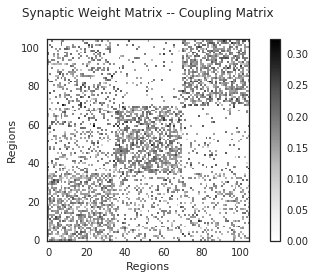

In [5]:
# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=True)

Note in this matrix:

`G[from, to]` : efferent connections  
`G[to, from]` : afferent connections  

### Rest activity

***Simulate resting state activity***

Apply neural network model **(Eq 3 in paper)** to the connectivity matrix and calculate each nodes' activity for each time point


**Note that this is still in synaptic space (i.e. not convolved)**

In [7]:
## Set up simulation parameters
#Tmaxrest = 60000 # 1min resting state data
Tmaxrest = 300000 # 5min resting state data
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0

When generating `restdata` the `noise` argument is not set to `None` because change in activity is defined as `spont_act = (noise[:,t] + I[:,t])`. When there is no task defined in `I` if `noise` is set to `None` then there is no activity. Thus `restdata` is conceived of as just noise.

In [ ]:
restdata = model.networkModel(G, 
                              Tmax=Tmaxrest,
                              dt=dt,
                              g=g,
                              s=s,
                              tau=tau,
                              I=None,
                              noise = 1)[0]

In [ ]:
plt.figure()
plt.imshow(restdata, aspect='auto',origin='lower')
plt.title('Simulated resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

### Task activity 

***Hub network stimulation***

In [8]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
#Tmax = 10000
Tmax = 300000 #increased to 5 minutes

T = np.arange(0,Tmax,dt)
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
        tasktiming[0,t] = 1.0

Block design where stimulus is ON for 500 ms every 2 seconds looks like:

In [ ]:
plt.plot(T[:10000], tasktiming[0,:10000])
plt.ylim(top = 1.2, bottom = -0.1)

In [9]:
stimtimes = {}

topdown_only = range(1,2)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

# When task is ON the activity for a stim_node at that time point is .5
for t in range(len(T)):
    if tasktiming[0,t] == 1:
        stimtimes[task][stim_nodes,t] = .5

Activated nodes in the hub network *only* (making it a top-down task) are:

In [ ]:
stim_nodes

When generating task data `model.networkModel` does **NOT** directly use restdata generated above. It uses the **weight matrix G.**

Activity is generated and updated as follows in `model.networkModel`: 

```
Enodes = np.zeros((totalnodes,len(T)))
Einit = np.random.rand(totalnodes,)
Enodes[:,0] = Einit

k1e = -Enodes[:,t] + phi(Enodes[:,t]) + np.dot(G,phi(I[:,t])) + I[:,t]

k2e = -(Enodes[:,t] + k1e) + phi(Enodes[:,t] + k1e) + np.dot(G,phi(I[:,t+1])) + I[:,t+1]

Enodes[:,t+1] = Enodes[:,t] + (.5*(k1e+k2e))
```

Enodes is the activity for all nodes in rows for all time points in columns.

The loop updates all rows of each column of Enodes, i.e. the activity for time step t+1 for all nodes.  

Activity in next time point is current activity PLUS some change.  

The change is the average of k1e and k2e.  

k1e is equation 3 using current time step so minus current activity, plus transformed current activity, plus sum of transformed activity in all other nodes weighted by the connectivity matrix, plus task activity in current time step.          

k2e is eqaution 3 again but this time using what would have been activity in t+1 if t+1 depended only on t. 

In [10]:
out = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)
taskdata = out[0]
noise = out[1]
#taskdata = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
#                                          I=stimtimes[task], noise=1)

In [13]:
taskdata_short = copy.copy(taskdata[:,:10000])

In [27]:
y = copy.copy(taskdata_short)
I = stimtimes[task][:,:10000]

In [19]:
ntimepoints = y.shape[1]

In [41]:
i = 501
next_y = y[:,i+1]
cur_y = y[:, i]
phi_cur_y = phi(cur_y)
cur_others = y[:, i]
phi_cur_others = phi(cur_others)
cur_I_phi = phi(I[:, i])
X = np.concatenate((phi_cur_y.reshape(-1,1), cur_I_phi.reshape(-1,1)), 1)

In [49]:
X[:15]

array([[-0.4781489 ,  0.46211716],
       [ 0.27689509,  0.46211716],
       [ 0.51354034,  0.46211716],
       [ 0.87915183,  0.46211716],
       [ 0.41378058,  0.46211716],
       [ 0.14576101,  0.46211716],
       [-0.89748792,  0.46211716],
       [ 0.66885839,  0.46211716],
       [-0.39491772,  0.        ],
       [-0.94199404,  0.        ],
       [ 0.23903453,  0.        ],
       [ 0.12063802,  0.        ],
       [-0.86047354,  0.        ],
       [ 0.23509014,  0.        ],
       [ 0.76419339,  0.        ]])

In [ ]:
#All other nodes activity for a given time point
stimtimes[task][:,0].shape

In [51]:
#GET TO T1 USING T0 AND THE OTHER TERMS IN THE EQUATIONS ABOVE
t0 = taskdata[0, 0]
t1 = taskdata[0, 1]
I = stimtimes[task]
t0

0.6977845865761431

In [52]:
t1

0.05580042643291094

In [53]:
spont_act = (noise[:,0] + I[:,0])
k1e = -t0 + np.dot(G,phi(spont_act))[0]
k1e += phi(t0) + spont_act[0]
# 
ave = t0 + k1e
#
# With auto-correlation
spont_act = (noise[:,0+1] + I[:,1])
k2e = -ave + np.dot(G,phi(spont_act))[0]
k2e += phi(ave) + spont_act[0]

t0 + (.5*(k1e+k2e))

0.05580042643291094

In [ ]:
spont_act = (noise[:,0] + I[:,0])
k1e = -t0 + np.dot(G,phi(spont_act))[0] + phi(t0) + spont_act[0]
# 
ave = t0 + k1e
#
# With auto-correlation
spont_act = (noise[:,0+1] + I[:,1])
k2e = -(np.dot(G,phi(spont_act))[0] + phi(t0) + spont_act[0]) + np.dot(G,phi(spont_act))[0] 
        + phi(np.dot(G,phi(spont_act))[0] + phi(t0) + spont_act[0]) + spont_act[0]

t0 + (.5*(k1e+k2e))

In [54]:
#how is this different than the way I describe the relationship between t0 and t1 in extending the standard glm?
#t1 ~ t0 + weighted other nodes' activity at t0 + task activity
phi(t0)+sum(G[0,1:]*phi(taskdata[1:,0]))+I[0,0]+noise[0,0]
#Vastly different

2.7487424419298576

In [ ]:
phi(t0)+sum(G[0,:]*phi(I[:,0]+noise[:,0]))+I[0,0]+noise[0,0]

Could I write a function that generated data the way I describe it in the regression framework? 

I don't think so because I don't know the activity in all the other nodes when updating the activity for one node at one time step (i.e. **`out[:,j]`**). Except for the first time step where the activity in the first step for all other nodes is random but would not be updated for the next time step 


```
def networkModelGlm(G, I, s, g, noise):
    nnodes = I.shape[0]
    timepoints = I.shape[1]
    out = np.zeros((nnodes, timepoints))
    
    #Initial random activity
    out[:,0] = np.random.rand(nnodes,)
    
    for i in range(nnodes):
        for j in range(timepoints):
            out[i,j+1] = phi(out[i]) + sum(np.dot(G[i,:], out[:,j])) + I[i, j] + noise[i, j]
            
    return(out) 
```

In [ ]:
#how do I get from t0 + (.5*(k1e+k2e)) to G = f(t0, t1, noise, I)



In [ ]:
plt.figure()
plt.imshow(taskdata, aspect='auto',origin='lower')
plt.title('Simulated single topdown task activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

## Extending GLM to recover true task activity and connectivity matrix

Note: Extending the GLM in this way is intended to account for the connectivity between nodes and how **task** activity in the previous step affects task activity in the current step for a given node. I don't think this is the same thing as 'subtracting out' resting state to look at the remaining task activity.

In [ ]:
#Using first third of the data for speed of estimation
taskdata_short = copy.copy(taskdata[:,:10000])

In [ ]:
x = copy.copy(stimtimes[task][0,:10000].T)
y = copy.copy(taskdata_short)

In [ ]:
def recover_pars(x, y, p = 1):
        
    ntimepoints = y.shape[1]
    nregions = y.shape[0]
    
    #Initialize empty variables
    task_glm = np.zeros((nregions))
    cur_node_ext_ucr = np.zeros((nregions)) 
    weight_matrix_ext_ucr = np.zeros((nregions, nregions-1))
    task_ext_ucr = np.zeros((nregions))
    cur_node_ext_arc = np.zeros((nregions))
    weight_matrix_ext_arc = np.zeros((nregions, nregions-1))
    task_ext_arc = np.zeros((nregions))
    cur_node_ext_pw = np.zeros((nregions))
    weight_matrix_ext_pw = np.zeros((nregions, nregions-1))
    task_ext_pw = np.zeros((nregions))

    #design matrix/task regressor
    task_reg = copy.copy(x)
    
    for region in range(0, nregions):
    
    #STANDARD GLM  
        cur_y = y[region,:]
        mod_glm = sm.OLS(cur_y, task_reg)
        res_glm = mod_glm.fit()
        task_glm[region] = res_glm.params[0]
        
    #EXTENDED GLM    
    #UCR pars
        
        # New y: Shift time course up and drop last time point to model activity in next time step
        cur_yp1 = np.roll(cur_y, -1)[:-1]
        
        # Make design matrix
        # Add current nodes activity in current time step dropping last time step
        cur_node = cur_y[:-1].reshape(-1,1)
        cur_node_t = np.apply_along_axis(phi, 0, cur_node)
        
        # Add other nodes' activity in current time step dropping last time step
        drop_region = [region]
        other_nodes = np.delete(y, drop_region, axis=0)
        other_nodes = other_nodes[:,:-1]
        other_nodes = other_nodes.T
        other_nodes_t = np.apply_along_axis(phi, 0, other_nodes)
        
        ucr_des_mat = np.concatenate((cur_node_t, other_nodes_t), 1)
        
        # Add task activity in current time step
        ucr_des_mat = np.concatenate((ucr_des_mat, task_reg[:-1].reshape(-1,1)), 1)
        
        #Run model and extract parameters
        mod_ext_ucr = sm.OLS(cur_yp1, ucr_des_mat)
        res_ext_ucr = mod_ext_ucr.fit()
        cur_node_ext_ucr[region] = res_ext_ucr.params[0]
        #weight_matrix_ext_ucr[region,:] = res_ext_ucr.params[1:-1]
        weight_matrix_ext_ucr[region,:] = res_ext_ucr.params[2:nregions+1]
        task_ext_ucr[region] = res_ext_ucr.params[-1]
    
    #ARC pars
        # Add untransformed activity in current node for current time step
        arc_des_mat = np.concatenate((ucr_des_mat, cur_node), 1)
        
        # Add transformed activity in current node from previous time step
        cur_node_m1 = np.roll(cur_node, 1)
        cur_node_m1[0] = 0
        cur_node_m1_t = np.apply_along_axis(phi, 0, cur_node_m1)
        arc_des_mat = np.concatenate((arc_des_mat, cur_node_m1_t), 1)
        
        # Add transformed activity from other nodes from previous time step
        other_nodes_m1 = np.roll(other_nodes, 1, axis=0)
        other_nodes_m1[0] = 0
        other_nodes_m1_t = np.apply_along_axis(phi, 0, other_nodes_m1)
        arc_des_mat = np.concatenate((arc_des_mat, other_nodes_m1_t), 1)
        
        # Add task activity from previous time step
        task_reg_m1 = np.roll(task_reg[:-1], 1)
        task_reg_m1[0] = 0
        task_reg_m1 = task_reg_m1.reshape(-1,1)
        
        arc_des_mat = np.concatenate((arc_des_mat, task_reg_m1), 1)
        
        #Run model and extract parameters
        mod_ext_arc = sm.OLS(cur_yp1, arc_des_mat)
        res_ext_arc = mod_ext_arc.fit()
        cur_node_ext_arc[region] = res_ext_arc.params[0]
        weight_matrix_ext_arc[region,:] = res_ext_arc.params[1:nregions]
        task_ext_arc[region] = res_ext_arc.params[nregions]
        
    #PW pars
    
        # Extract errors from res_ext_ucr
        err_ext_ucr = res_ext_ucr.resid
        
        # Run AR(p) model on residuals
        try:
            ar_mod = ARMA(err_ext_ucr, order=(p, 0))
            ar_res = ar_mod.fit(trend="nc")
            ar_est = ar_res.params
            
        # Prewhiten cur_yp1 and ucr_des_mat
            shift_y = pshift(cur_yp1, p)
            shift_X = pshift(ucr_des_mat, p)
            mpw_y = cur_yp1 - (ar_est*shift_y)
            mpw_X = ucr_des_mat - (ar_est*shift_X)
            mod_ext_pw = sm.OLS(mpw_y, mpw_X)
            res_ext_pw = mod_ext_pw.fit()
            cur_node_ext_pw[region] = res_ext_pw.params[0]
            weight_matrix_ext_pw[region,:] = res_ext_pw.params[1:-1]
            task_ext_pw[region] = res_ext_pw.params[-1]
        
        except:
            print('Whitening failed!')
            cur_node_ext_pw[region] = np.nan
            weight_matrix_ext_pw[region:] = np.nan
            task_ext_pw[region] = np.nan
            ar_est = np.nan
    
    
    out = {'task_glm':task_glm,
           'cur_node_ext_ucr':cur_node_ext_ucr,
           'weight_matrix_ext_ucr':weight_matrix_ext_ucr,
           'task_ext_ucr': task_ext_ucr,
           'cur_node_ext_arc':cur_node_ext_arc,
           'weight_matrix_ext_arc':weight_matrix_ext_arc,
           'task_ext_arc':task_ext_arc,
           'cur_node_ext_pw':cur_node_ext_pw,
           'weight_matrix_ext_pw':weight_matrix_ext_pw,
           'task_ext_pw':task_ext_pw,
           'ar_est': ar_est}
    
    return (out)

In [ ]:
out = recover_pars(x, y)

#### Task betas reduced after correction?


In [ ]:
task_betas = pd.DataFrame(data = {'task_glm': out['task_glm'],
                         'task_ext_ucr': out['task_ext_ucr'],
                         'task_ext_arc': out['task_ext_arc'],
                         'task_ext_pw': out['task_ext_pw']})

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(task_betas['task_glm'], color = "blue", label = "Classic GLM")
plt.plot(task_betas['task_ext_ucr'], color = "green", label = "Extended GLM no ARC")
plt.plot(task_betas['task_ext_arc'], color = "red", label = "Extended GLM ARC")
plt.plot(task_betas['task_ext_pw'], color = "purple",label = "Extended GLM PW")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='gray', ls = "--")
plt.axhline(y=0,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

#### Current node betas == 1?

In [ ]:
cur_node_betas = pd.DataFrame(data = {'cur_node_ext_ucr': out['cur_node_ext_ucr'],
                         'cur_node_ext_arc': out['cur_node_ext_arc'],
                         'cur_node_ext_pw': out['cur_node_ext_pw']})

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(cur_node_betas['cur_node_ext_ucr'], color = "green",label = "Extended GLM no ARC")
plt.plot(cur_node_betas['cur_node_ext_arc'], color = "red",label = "Extended GLM ARC")
plt.plot(cur_node_betas['cur_node_ext_pw'], color = "purple",label = "Extended GLM PW")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

#### Other node betas recapitulate connectivity matrix?

**Relationship between other nodes betas and the afferent connectivity weights (can you recover the connectivity matrix?)**

In [ ]:
nregions = y.shape[0]
weight_matrix_betas_ucr = np.zeros((nregions,nregions))
weight_matrix_betas_arc = np.zeros((nregions,nregions))
weight_matrix_betas_pw = np.zeros((nregions,nregions)) 
for i in range(nregions):
    weight_matrix_betas_ucr[i] = np.insert(out['weight_matrix_ext_ucr'][i],i,0)
    weight_matrix_betas_arc[i] = np.insert(out['weight_matrix_ext_arc'][i],i,0)
    weight_matrix_betas_pw[i] = np.insert(out['weight_matrix_ext_pw'][i],i,0)

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_ucr, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_arc, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_pw, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()